In [2]:
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for sklearn, since package 'wheel' is not installed.
    Running setup.py install for sklearn ... done


In [4]:
!pip install DBSCAN

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 9.6 MB 5.7 MB/s            


In [6]:
!pip install -U scikit-learn scipy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 10.9 MB 5.8 MB/s            
     |████████████████████████████████| 301 kB 76.1 MB/s            


In [1]:
#import section
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import warnings
from sklearn.cluster import DBSCAN
warnings.filterwarnings(action='ignore')
%matplotlib inline

### Load Event CSVs into Pandas Dataframe

In [2]:
#show the full content of the column
pd.set_option('display.max_colwidth', None)

In [3]:
#read latest events dataset into pandas dataframe
dfev = pd.read_csv('events_init2.csv', encoding='utf-8')

In [4]:
dfev.shape

(858777, 9)

In [5]:
#print 5 rows from dataframe
dfev.head(5)

,device_id,event_id,event_time,latitude,longitude,gender,age,group_train,age_group
0,-7548291590301750000,2279193,2016-05-03 03:10:01,116.79,33.98,M,33,M32+,32+
1,-7548291590301750000,1121009,2016-05-03 15:37:40,116.79,33.98,M,33,M32+,32+
2,-7548291590301750000,1121005,2016-05-03 15:33:51,116.79,33.98,M,33,M32+,32+
3,-7548291590301750000,1113814,2016-05-01 10:27:52,116.79,33.98,M,33,M32+,32+
4,-7548291590301750000,1113205,2016-05-04 09:10:43,116.79,33.98,M,33,M32+,32+


#### Observation:  From the below graph, the cluster formation will be within the range of
    Latitude - 20 to 50
    Longitude - 80 to 120

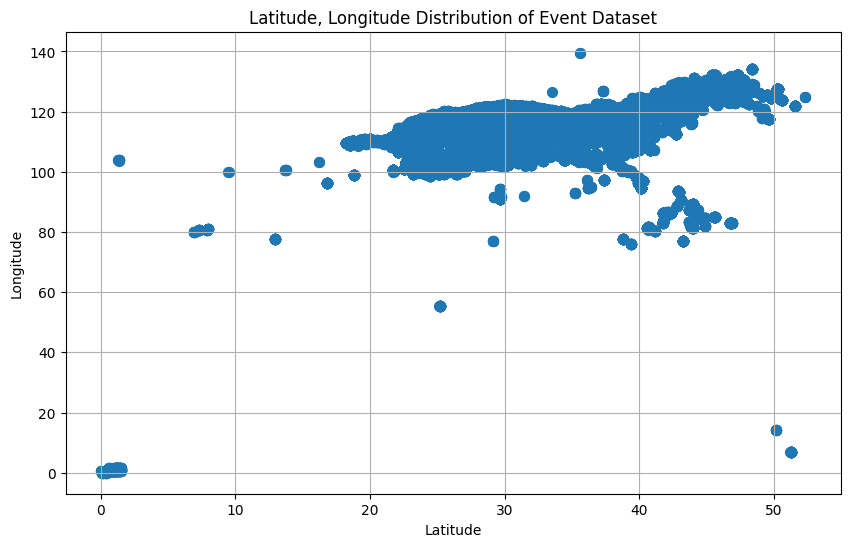

In [6]:
#plot the distribution of latitude, longitude of event data
plt.figure(figsize=(10, 6))
plt.scatter(dfev['longitude'],dfev['latitude'], s = 50)
plt.grid(True)
plt.title('Latitude, Longitude Distribution of Event Dataset')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [7]:
#take only unique latitude, longitude coordinates
dfsub = dfev[['longitude','latitude']]
print('before dropping duplicates =',dfsub.shape)
dfsub.drop_duplicates(inplace=True)
print('after dropping duplicates=',dfsub.shape)

before dropping duplicates = (858777, 2)
after dropping duplicates= (32855, 2)


In [8]:
#convert latitude, longitude to numpy co-ordinates
coords = dfsub[['longitude','latitude']].to_numpy()
coords.shape

(32855, 2)

In [9]:
coords.min(), coords.max()

(0.01, 139.56)

In [10]:
#drop duplicate latitude & longitude coordination.
unique_coords = np.unique(coords, axis=0)
unique_coords.shape

(32855, 2)

In [11]:
unique_coords.min(), unique_coords.max()

(0.01, 139.56)

In [12]:
unique_coords

array([[1.0000e-02, 4.8000e-01],
       [1.1000e-01, 7.0000e-02],
       [1.4000e-01, 2.3000e-01],
       ...,
       [5.1560e+01, 1.2173e+02],
       [5.1560e+01, 1.2174e+02],
       [5.2320e+01, 1.2470e+02]])

In [13]:
#convert lat,long coordinates into radians
latlong_radians = np.radians(unique_coords)
latlong_radians

array([[1.74532925e-04, 8.37758041e-03],
       [1.91986218e-03, 1.22173048e-03],
       [2.44346095e-03, 4.01425728e-03],
       ...,
       [8.99891762e-01, 2.12458930e+00],
       [8.99891762e-01, 2.12476383e+00],
       [9.13156265e-01, 2.17642558e+00]])

In [14]:
#compute DBScan.  min_samples = 1 ensures there will be no outliers.
kms_per_radian = 6371.0088
#epsilon = 1.5/kms_per_radian
#eps 10, min_sample 200 : 10, 1
#best so far eps=.1, min_samples=150,results 3 cluster
#  eps=.05, min_samples=20,results 4 cluster
#  eps=.025, min_samples=10,results 8 cluster
epsilon = 5/kms_per_radian
db = DBSCAN(eps = 0.025, min_samples = 10, algorithm = 'ball_tree', metric = 'haversine').fit(latlong_radians)

In [15]:
cluster_labels = db.labels_
n_clusters = len(set(cluster_labels))
print('Number of clusters:', n_clusters, ' cluster ids=',set(cluster_labels))

Number of clusters: 8  cluster ids= {0, 1, 2, 3, 4, 5, 6, -1}


In [16]:
#update the cluster id in subset dataframe first
dfsub['cluster_id'] = db.labels_
dfsub['cluster_id'] = dfsub['cluster_id']
dfsub['cluster_id'].value_counts(ascending=False)

cluster_id
 1    32266
 6      198
 0      150
-1       95
 3       92
 5       26
 4       15
 2       13
Name: count, dtype: int64

In [17]:
#cluster id -1 means outlier.  Check for outlier existance.
dfsub[dfsub['cluster_id'] == -1]

,longitude,latitude,cluster_id
3718,30.85,104.19,-1
3726,30.58,104.13,-1
3739,30.67,103.98,-1
3740,30.64,104.12,-1
3825,30.66,104.02,-1
...,...,...,...
858736,30.25,119.94,-1
858748,47.77,123.19,-1
858752,34.78,118.70,-1
858762,30.79,120.69,-1


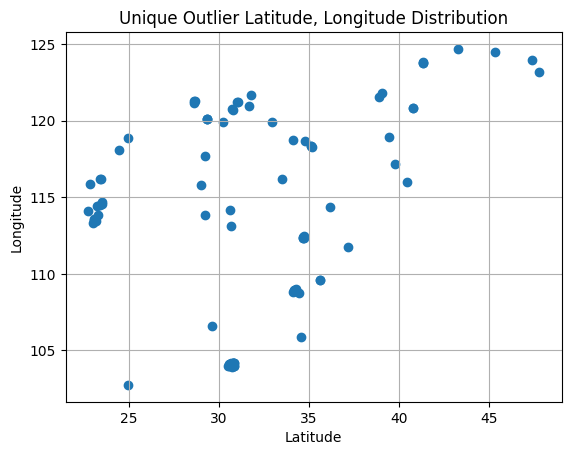

In [18]:
#plot the outlier cluster
#.plot(kind='scatter', dfsub['longitude'], dfsub['latitude'])
x = dfsub[dfsub['cluster_id'] == -1]['longitude']
y = dfsub[dfsub['cluster_id'] == -1]['latitude']
plt.scatter(x, y)
plt.grid(True)
plt.title('Unique Outlier Latitude, Longitude Distribution')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

#### Adding cluster_id as a feature in  event dataset

In [ ]:
#initialise cluster id in event dataset
dfev['cluster_id'] = -1

#Iterate the subset. read the cluster id for a unique lat, lng combination and assign the cluster id to event dataset.
for idx, row in dfsub.iterrows():
    cluster_id = row.cluster_id
    lng = row.longitude
    lat = row.latitude
    #dfsub.at[idx,'cluster_id'] = cluster_id
    dfev.loc[((dfev['longitude'] == lng) & (dfev['latitude'] == lat)),['cluster_id']] = cluster_id
    print('processing subset row:',idx,': cluster id ',cluster_id, 'updated in event dataset')
    #break;

processing subset row: 0 : cluster id  0.0 updated in event dataset
processing subset row: 292 : cluster id  0.0 updated in event dataset
processing subset row: 296 : cluster id  0.0 updated in event dataset
processing subset row: 298 : cluster id  0.0 updated in event dataset
processing subset row: 328 : cluster id  0.0 updated in event dataset
processing subset row: 331 : cluster id  0.0 updated in event dataset
processing subset row: 334 : cluster id  0.0 updated in event dataset
processing subset row: 367 : cluster id  0.0 updated in event dataset
processing subset row: 369 : cluster id  0.0 updated in event dataset
processing subset row: 383 : cluster id  0.0 updated in event dataset
processing subset row: 385 : cluster id  0.0 updated in event dataset
processing subset row: 387 : cluster id  0.0 updated in event dataset
processing subset row: 398 : cluster id  0.0 updated in event dataset
processing subset row: 409 : cluster id  0.0 updated in event dataset
processing subset row:

In [ ]:
#verify the shape after updating cluster_id
dfev.shape

In [ ]:
#view the dataset after updating cluster_id
dfev

In [ ]:
cluster_det = dfev['cluster_id'].value_counts(ascending=False)
cluster_det

In [ ]:
#Now that cluster is assigned to each co-ordinate.  plot the coordinates for each cluster
#.plot(kind='scatter', dfsub['longitude'], dfsub['latitude'])
plt.figure(figsize=(10,5))
plt.scatter(dfev[dfev['cluster_id'] == -1]['longitude'], dfev[dfev['cluster_id'] == -1]['latitude'], alpha = 0.5, zorder = 2, label='Cluster -1 (outlier)')
plt.scatter(dfev[dfev['cluster_id'] == 0]['longitude'], dfev[dfev['cluster_id'] == 0]['latitude'], alpha = 0.5, zorder =  2, label='Cluster 0')
plt.scatter(dfev[dfev['cluster_id'] == 1]['longitude'], dfev[dfev['cluster_id'] == 1]['latitude'], alpha = 0.5, zorder = 1, label='Cluster 1')
plt.scatter(dfev[dfev['cluster_id'] == 2]['longitude'], dfev[dfev['cluster_id'] == 2]['latitude'], alpha = 0.5, zorder = 1, label='Cluster 2')
plt.scatter(dfev[dfev['cluster_id'] == 3]['longitude'], dfev[dfev['cluster_id'] == 3]['latitude'], alpha = 0.5, zorder = 1, label='Cluster 3')
plt.scatter(dfev[dfev['cluster_id'] == 4]['longitude'], dfev[dfev['cluster_id'] == 4]['latitude'], alpha = 0.5, zorder = 1, label='Cluster 4')
plt.scatter(dfev[dfev['cluster_id'] == 5]['longitude'], dfev[dfev['cluster_id'] == 5]['latitude'], alpha = 0.5, zorder = 1, label='Cluster 5')
plt.scatter(dfev[dfev['cluster_id'] == 6]['longitude'], dfev[dfev['cluster_id'] == 6]['latitude'], alpha = 0.5, zorder = 1, label='Cluster 6')
plt.grid(True)
plt.title('Cluster wise Latitude, Longitude Distribution')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.show()

In [ ]:
#save event dataframe to csv
dfev.to_csv(r'events_dbscan3.csv', index = False)

In [ ]:
#upload events csv to S3
!aws s3 cp events_dbscan3.csv s3://capstone-mm/final_submission/events_dbscan3.csv